### Using Bollinger Bands as Trading Strategy?

I recently learned about Bollinger Bands as stock metric. Bollinger Bands show the volaltility of the stock. The bands themselves show the price that is two standard deviations above and below the 20 day rolling mean stock price. When I learned about them, it was explicitly stated that Bollinger Bands do not constitute a trading strategy and should not be used as buy and sell signals. However, to a relatively naive trader like myself, it seemed like could work as a way to ensure I could "buy low and sell high". I decided this would be a good chance to get some experience working with financial data and test my intuition.

For this investigation, I'll need to get my hands on some historical stock data. This can be done pretty quickly using the Quandl API. It only took me about 5 minutes to get an API key so I could start going through the data. To get the data, I borrowed the function below from [Chris Conlan](https://chrisconlan.com/download-historical-stock-data-google-r-python/ "Chris Conlan").

The first stock I ever traded was Apple, back around 2010-2011. I didn't do a very good job with it. I bought maybe three shares, waited a few weeks and then sold one of them. Then when the price kept going up, I sold another one. I made a little bit of money, but then the price kept going up and I never reinvested. I'm going to start by testing my strategy on Apple to see if I could have done better. Let's grab the data.

In [18]:
import quandl
import datetime
 
quandl.ApiConfig.api_key = 'wesz_LiK8sqEPe6jFDqs'
 
def quandl_stocks(symbol, start_date=(2000, 1, 1), end_date=None):
    """
    symbol is a string representing a stock symbol, e.g. 'AAPL'
 
    start_date and end_date are tuples of integers representing the year, month,
    and day
 
    end_date defaults to the current date when None
    """
 
    query_list = ['WIKI' + '/' + symbol + '.' + str(k) for k in range(1, 13)]
 
    start_date = datetime.date(*start_date)
 
    if end_date:
        end_date = datetime.date(*end_date)
    else:
        end_date = datetime.date.today()
 
    return quandl.get(query_list,
            returns='pandas',
            start_date=start_date,
            end_date=end_date,
            collapse='daily',
            order='asc'
            )
apple_data = quandl_stocks('AAPL')

Here's what it looks like:

In [19]:
from IPython.display import display
display(apple_data.head())

,WIKI/AAPL - Open,WIKI/AAPL - High,WIKI/AAPL - Low,WIKI/AAPL - Close,WIKI/AAPL - Volume,WIKI/AAPL - Ex-Dividend,WIKI/AAPL - Split Ratio,WIKI/AAPL - Adj. Open,WIKI/AAPL - Adj. High,WIKI/AAPL - Adj. Low,WIKI/AAPL - Adj. Close,WIKI/AAPL - Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


Each row shows data from a single day and includes the open, high, low, and close price, the volume, dividend, split ratio, and adjusted prices and volume. For this simulation, I'm going to focus on just the Adjusted Close price. 

I always like to visualize the data before doing any analysis to get an over-all feel for what I'm working with. I'm going to use bokeh for this plot because it allows for interactive plotting within the Jupyter Notebook. This makes it easier to explore the data without have to keep adjusting the plot and re-running the code if we spot something interesting.

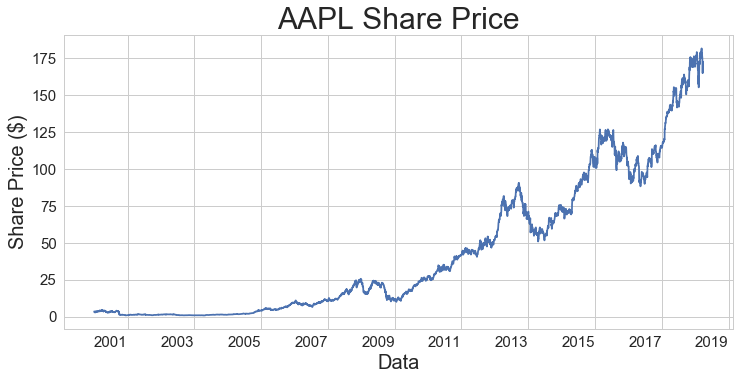

In [20]:
# use bokeh for interactive plotting
#from bokeh.plotting import figure, output_notebook, show
# output to static HTML file
#output_notebook()
# create a new plot with a title and axis labels
#p = figure(title="Apple Stock", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(apple_data.index, apple_data['WIKI/AAPL - Adj. Close'], legend="Adj. Close", line_width=2)
# show the results
#show(p)

# use matplotlib for final plots
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12,6))
apple_data['WIKI/AAPL - Adj. Close'].plot(kind='line', ax=ax,
                                         fontsize=15,
                                         rot=0)
ax.set_ylabel('Share Price ($)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('AAPL Share Price', fontsize=30);

In [38]:
# Cumulative return of AAPL
print(apple_data['WIKI/AAPL - Adj. Close'].iloc[-1])
print(apple_data['WIKI/AAPL - Adj. Close'].iloc[0])
cr = ((apple_data['WIKI/AAPL - Adj. Close'].iloc[-1]/apple_data['WIKI/AAPL - Adj. Close'].iloc[0]) - 1)*100
print('AAPL cumulative return {:.2f}%'.format(cr))

168.34
3.59646254515
AAPL cumulative return 4580.71%


Obviously, Apple has done very well. There are some occasional sharp dips in the price, but mostly it just keeps going up. Really wish I would have held on to all three of those shares I purchased back in the day.

Now that we have the data, I can simulate the Bollinger Band trading strategy. Here's my stategy I want to try:

1. If the price of the stock goes below the bottom Bollinger Band, buy \$100 worth of shares.
2. If the price of the stock goes above the upper Bollinger Band, sell 50% of the shares I own.

To do this, I will create a BollingerBands object. This will keep track of all the data, such as current balance and amount of shares owned needed to perform the simulation.


In [4]:
class BollingerBands:
    """A class to simulate a Bolliner Band trading strategy"""
    def __init__(self, stock, window=20, balance=3000, shares=0, sell_per=0.5, buy_amt=100, width=2, commission=10):
        self.stock = stock # daily stock price
        self.window = window # window size to compute rolling mean and Bollinger Bands
        self.start_balance = balance # starting amount of cash
        self.balance = balance # current cash balance
        self.shares = shares # shares owned
        self.commission = commission # amount I would need to pay a broker to execute the trade
        self.sell_per = sell_per # % of shares to sell on each sell signal
        self.buy_amt = buy_amt # $ amount of shares to buy on each buy signal
        self.rmean = self.stock.rolling(self.window).mean() # the rolling mean stock price
        self.upper = self.stock.rolling(self.window).mean() + width*self.stock.rolling(self.window).std() # upper band
        self.lower = self.stock.rolling(self.window).mean() - width*self.stock.rolling(self.window).std() # lower band
        self.results = pd.concat([self.stock.copy()]*4,axis=1) # create a dataframe to fill with results calculated later
        self.results.columns = ['Balance','Shares','Profit','n_shares'] # the names of the results columns
        
    def trade(self):
        # simluate the trading strategy
        for i in self.stock.index:
            if self.stock.loc[i] > self.buy_amt:
                self.buy_amt = self.buy_amt*2
            if (self.stock.loc[i] > self.upper.loc[i]) and self.shares > 0:
                # sell 50% of shares at the stock price
                profit = self.stock.loc[i] * int(self.shares*self.sell_per) # calc sell profit
                self.balance = self.balance + profit - self.commission# update balance and shares
                self.shares = int(self.shares*self.sell_per)
                self.results.loc[i,'Profit'] = profit
                #print('SELL {} shares for ${:.2f}/share = {:.2f} profit'.format(self.shares,self.stock.loc[i],profit))
            if self.stock.loc[i] < self.lower.loc[i]:
                n_shares = int(self.buy_amt/self.stock.loc[i]) # how many shares can be bought
                # make sure I can afford that many shares
                if self.balance - self.commission - (n_shares*self.stock.loc[i]) < 0:
                    n_shares = int((self.balance - self.commission)/self.stock.loc[i])
                    #print("can't buy that many shares, buy as many as you can")
                #print('BUY ${} of shares for ${:.2f}/share = {} shares acquired'.format(self.buy_amt,self.stock.loc[i],n_shares))
                if n_shares > 0:
                    self.balance = self.balance - (n_shares*self.stock.loc[i]) - self.commission
                    self.shares = self.shares + n_shares
                self.results.loc[i,'n_shares'] = n_shares
            self.results.loc[i,'Balance'] = self.balance
            self.results.loc[i,'Shares'] = self.shares
        #print(self.balance, self.shares)
        
    def buy_and_hold(self):
        # calculate the cumulative return at each point in time
        # how many shares can we buy at the beginning
        n_shares = int(self.start_balance/self.stock.iloc[0])
        # how much are those shares worth at the last time point
        buyandhold = n_shares * self.stock
        return buyandhold        

Remember: if the price breaks the upper band, sell 50% of my shares. If the price drops below the lower band, buy \$100 of shares. Let's start with assuming a an initial balance of \$500.

In [5]:
a = BollingerBands(apple_data['WIKI/AAPL - Adj. Close'], balance=500, window=20,commission=0)
a.trade()
baseline = a.buy_and_hold()

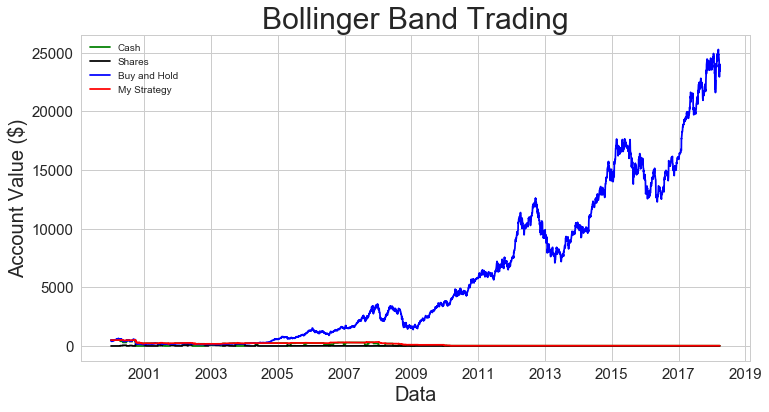

In [6]:
# create a new plot with a title and axis labels
#p = figure(title="Apple and Bollinger Bands", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(apple_data.index, a.results['Balance'], legend="Balance", line_width=2, color='red')
#p.line(apple_data.index, a.results['Shares'], legend="Shares", line_width=2, color='blue')
#p.line(apple_data.index, baseline, legend="Buy and Hold", line_width=2, color='green')
# my strategy returns include the value of owned shares and the cash balance
#p.line(apple_data.index, a.results['Shares']*a.stock+a.results['Balance'], legend='My Strategy', line_width=2, color='black')
#p.legend.location = "top_left"
#show(p)

# use matplotlib for final plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(apple_data.index, a.results['Balance'], label='Cash', c='g')
ax.plot(apple_data.index, a.results['Shares'], label='Shares', c='k')
ax.plot(apple_data.index, baseline, label='Buy and Hold', c='b')
ax.plot(apple_data.index, a.results['Shares']*a.stock+a.results['Balance'], label='My Strategy', c='r')
ax.legend()
ax.set_ylabel('Account Value ($)', fontsize=20)
ax.set_xlabel('Data', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title('Bollinger Band Trading', fontsize=30);

Well, look, looks like they advice they gave in the finance course had some merit. It's hard to see on this scale, but my final balance using the Bollinger Bands as a trading strategy is \$20. That is substantially less than the ~24K the buy-and-hold strategy would have earned me. The complete failure of this trading strategy is actually quite surprising to me. There are several parameters that went into this simulation that I can change to tweak my strategy. I'll spare you my exploration and show you that this type of trading strategy can beat the market. The winning combination is to change the window size for rolling mean calculation to 6 days and increasing the `buy_amt` to \$250. I also factored in trading commission. I dub the six day moving window and bands "Maxi Bands".

In [7]:
a = BollingerBands(apple_data['WIKI/AAPL - Adj. Close'], balance=500, window=6, buy_amt=250, 
                  commission=10)
a.trade()
baseline = a.buy_and_hold()

In [8]:
# create a new plot with a title and axis labels
#p = figure(title="Apple and Maxi Bands", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
#p.line(apple_data.index, a.results['Balance'], legend="Balance", line_width=2, color='red')
#p.line(apple_data.index, a.results['Shares'], legend="Shares", line_width=2, color='blue')
#p.line(apple_data.index, baseline, legend="Buy and Hold", line_width=2, color='green')
#p.line(apple_data.index, a.results['Shares']*a.stock+a.results['Balance'], legend='My Strategy', line_width=2, color='black')
#p.legend.location = "top_left"
#show(p)

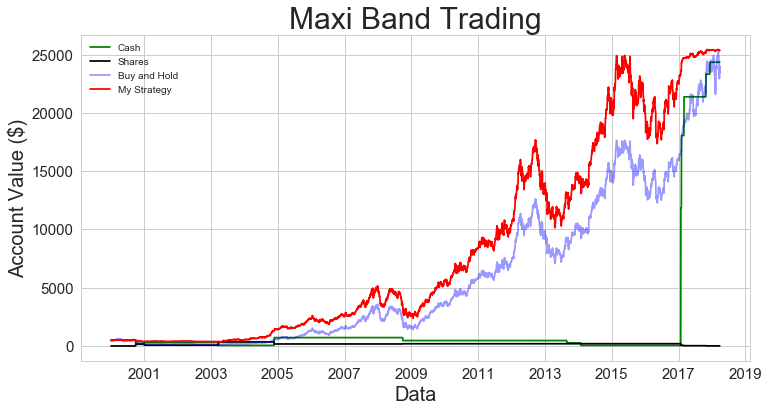

In [9]:
# use matplotlib for final plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(apple_data.index, a.results['Balance'], label='Cash', c='g')
ax.plot(apple_data.index, a.results['Shares'], label='Shares', c='k')
ax.plot(apple_data.index, baseline, label='Buy and Hold', c='b', alpha=0.4)
ax.plot(apple_data.index, a.results['Shares']*a.stock+a.results['Balance'], label='My Strategy', c='r')
ax.legend()
ax.set_ylabel('Account Value ($)', fontsize=20)
ax.set_xlabel('Data', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title('Maxi Band Trading', fontsize=30);

The "Maxi Bands" trading strategy actually is able to beat the buy-and-hold strategy for apple stock. The reason for this is actually because the price dropped precipitously at toward the end of 2000. This acted as a buy signal for my strategy, and resulted in my overal portfolio (cash + stocks) to preserve value compared to stocks alone. Essentially, I used a small amount of cash to buy stocks when they "went on sale". A second drop happened at the beginning of 2003, allowing me to get a large amount of stock for a low price. In the subsequent years, there were some steep price drops that set off some more buy signals. My balance then got too low to be able to afford to buy any more stocks. Then, there were several several signals and I exchanged shares for cash. The underlying cause of the success was that this strategy resulted in waiting to buy stocks when price went down from where it started, so I bought at close to the market minimum. The key to being successful is to make the `buy_amt` a sizable portion of (50% or more) of the starting balance. If the `buy_amt` is to small, then I can't buy enough shares when the price drops to surpass the baseline strategy of putting all my money into the stock right away.

The next question I have is, does this work on all time frames? We identified the role of the dip in the successful outcome. If we miss that dip, then we are likely going to miss out on success.

In [10]:
# pick to random indices to try my strategy on
start = apple_data['WIKI/AAPL - Adj. Close'].sample(1).index[0]
end = apple_data['WIKI/AAPL - Adj. Close'][start:].sample(1).index[0]
a = BollingerBands(apple_data['WIKI/AAPL - Adj. Close'].loc[start:end], balance=500, shares=0, buy_amt=250)
a.trade()
baseline = a.buy_and_hold()

# create a new plot with a title and axis labels
#p = figure(title="Maxi Bands, random time range", x_axis_label='Date', y_axis_label='Balance',x_axis_type='datetime')
# add a line renderer with legend and line thickness
x = apple_data.loc[start:end].index
#p.line(x, a.results['Balance'], legend="Balance", line_width=2, color='red')
#p.line(x, a.results['Shares'], legend="Shares", line_width=2, color='blue')
#p.line(x, baseline, legend="Buy and Hold", line_width=2, color='green')
#p.line(x, a.results['Shares']*a.stock+a.results['Balance'], legend='My Strategy Total', line_width=2, color='black')
#p.legend.location = 'top_left'
#show(p)

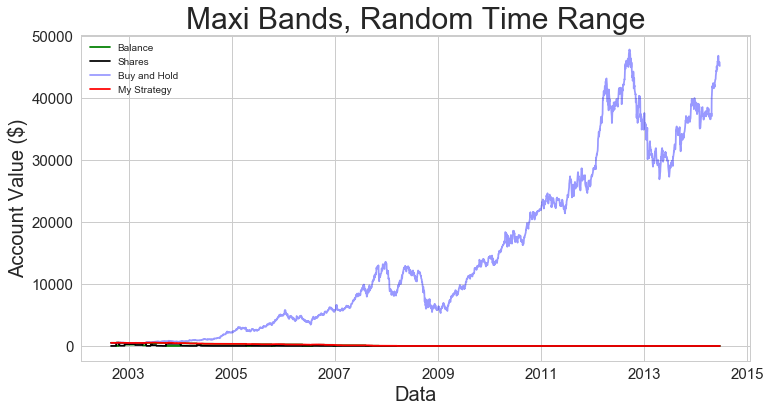

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, a.results['Balance'], label='Balance', c='g')
ax.plot(x, a.results['Shares'], label='Shares', c='k')
ax.plot(x, baseline, label='Buy and Hold', c='b', alpha=0.4)
ax.plot(x, a.results['Shares']*a.stock+a.results['Balance'], label='My Strategy', c='r')
ax.legend()
ax.set_ylabel('Account Value ($)', fontsize=20)
ax.set_xlabel('Data', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.set_title('Maxi Bands, Random Time Range', fontsize=30);

Here, my strategy did not work. The buy signal worked well and gave me a boost relative to buy-and-hold. However, the sell signal occurred before the top of the rise and I missed out on some extraordinary growth. Let's run this strategy on 100 different time frames to get an idea of how often it succeeds.

In [12]:
baseresults = []
myresults = []
for i in range(100):
    # pick to random indices to try my strategy on
    start = apple_data['WIKI/AAPL - Adj. Close'].sample(1).index[0]
    end = apple_data['WIKI/AAPL - Adj. Close'][start:].sample(1).index[0]
    a = BollingerBands(apple_data['WIKI/AAPL - Adj. Close'].loc[start:end], balance=500, window=6, buy_amt=250)
    a.trade()
    thisbaseline = a.buy_and_hold()
    baseresults.append(thisbaseline[-1])
    thisreturn = a.results['Shares']*a.stock+a.results['Balance']
    myresults.append(thisreturn[-1])

I'm going to convert the lists holding the results into a DataFrame to make it easier to analyze the results.

In [39]:
appleSim = pd.DataFrame({'Base':baseresults,'Maxi':myresults})
# convert dollar returns to percentages
appleSim = (appleSim/500)-1 # 500 was the starting balance
# use the describe function get some basic info
display(appleSim.describe())

,Base,Maxi
count,100.000000,100.000000
mean,13.322065,3.906125
std,27.743431,9.219569
min,-0.588799,-0.080931
25%,0.411118,0.000000
50%,2.403295,0.417969
75%,9.219698,2.923236
max,125.531720,39.566067


On average, I lost out to the buy-and-hold strategy. The mean and median are both lower in the Maxi column, although the large difference between the mean and the median indicates a large positive skew. The standard deviation is a measure of risk when evaluating stocks. There was actually less risk with my strategy. We can compare the distrubutions of the plots using a histogram. I am applying a log transformation to the data because of the postive skew indicated by the difference between the mean and the median.

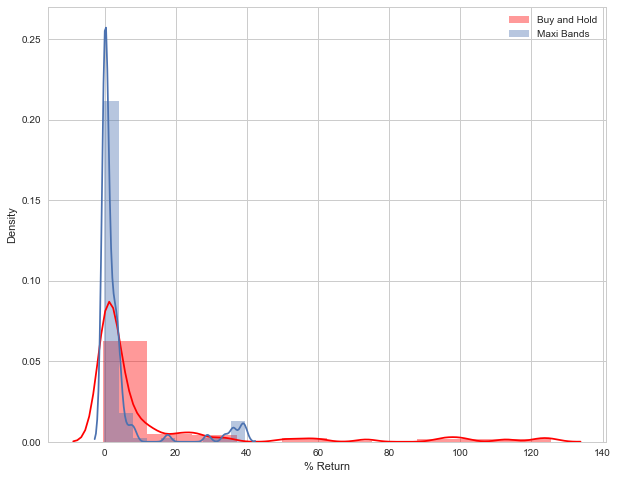

In [40]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(appleSim['Base'], bins=10, color='red', label='Buy and Hold', ax=ax)
ax = sns.distplot(appleSim['Maxi'], bins=10, label='Maxi Bands', axlabel='% Return')
ax.set_ylabel('Density')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

The histograms show that we are more likely to better returns with the buy-and-hold strategy. My strategy has less risk, as there is a relatively tighter distrubution around the mean return value. Let's do a quick t-test to confirm that the buy-and-hold strategy gives better returns.

In [41]:
from scipy.stats import ttest_ind
ttest_ind(appleSim['Base'], appleSim['Maxi'])

Ttest_indResult(statistic=3.2207515756363727, pvalue=0.0014946049556794191)

The average return of the buy-and-hold strategy is significantly greater than the Maxi Bands strategy. There is another important metric to consider, how often did my strategy beat the buy-and-hold strategy? We just need to see how many times the Maxi column is greater than the Base column.

In [42]:
(appleSim['Maxi']>appleSim['Base']).sum()

23

Looks like there is rougly a 20% chance of beating the market using my strategy (23/100) to trade AAPL. The last question I have is to see the difference between the two strategies after each time point.

median:  -0.950747476369914
mean:  -9.41593998099


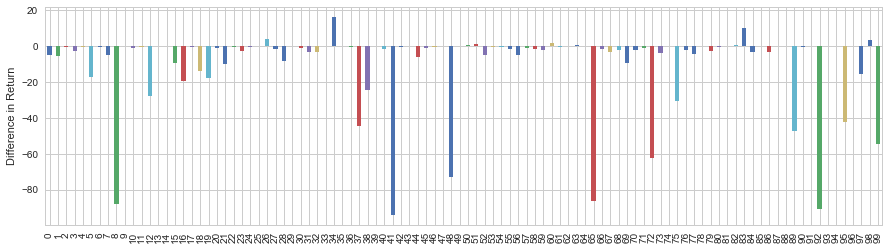

In [43]:
fig, ax = plt.subplots(figsize=(15,4))
(appleSim['Maxi']-appleSim['Base']).plot(kind='bar', ax=ax)
ax.set_ylabel('Difference in Return');
print('median: ', (appleSim['Maxi']-appleSim['Base']).median())
print('mean: ', (appleSim['Maxi']-appleSim['Base']).mean())

When my strategy does beat the market, it is not by much. And when it loses, the difference tends be sizable (median = -0.951%, mean = -9.42%).

### Conclusion
- My stategy does not work for trading AAPL stock.
- The return is typically 0.799% less
- The largest returns are possible using a buy-and-hold strategy, 10% return on average